Skipping incomplete record: {'id': 16395, 'img': 'img/16395.png', 'text': 'handjobs sold seperately'}
Skipping incomplete record: {'id': 37405, 'img': 'img/37405.png', 'text': 'introducing fidget spinner for women'}
Skipping incomplete record: {'id': 94180, 'img': 'img/94180.png', 'text': "happy pride month let's go beat up lesbians"}
Skipping incomplete record: {'id': 54321, 'img': 'img/54321.png', 'text': 'laughs in [majority of u.s crime rate]'}
Skipping incomplete record: {'id': 97015, 'img': 'img/97015.png', 'text': 'finds out those 72 virgins.. are goats'}
Skipping incomplete record: {'id': 73506, 'img': 'img/73506.png', 'text': 'look your dad fucked goats.. i capped him...sorry..'}
Skipping incomplete record: {'id': 5429, 'img': 'img/05429.png', 'text': 'claims that her ancestors created a safe space for jews these are her ancestors'}
Skipping incomplete record: {'id': 70691, 'img': 'img/70691.png', 'text': 'overdose'}
Skipping incomplete record: {'id': 69421, 'img': 'img/69421.

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.enco


Epoch 1/10


Evaluating: 100%|██████████| 225/225 [00:52<00:00,  4.27it/s]


Train Loss: 0.6564 | Val Loss: 0.6676 | Val Acc: 0.6172 | Val F1: 0.4711

Epoch 2/10


Evaluating: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]


Train Loss: 0.6543 | Val Loss: 0.6645 | Val Acc: 0.6172 | Val F1: 0.4711

Epoch 3/10


Evaluating: 100%|██████████| 225/225 [00:42<00:00,  5.30it/s]


Train Loss: 0.6480 | Val Loss: 0.6667 | Val Acc: 0.6172 | Val F1: 0.4711

Epoch 4/10


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.51it/s]


Train Loss: 0.6415 | Val Loss: 0.6431 | Val Acc: 0.6406 | Val F1: 0.6203

Epoch 5/10


Evaluating: 100%|██████████| 225/225 [00:42<00:00,  5.31it/s]


Train Loss: 0.6127 | Val Loss: 0.6233 | Val Acc: 0.6617 | Val F1: 0.6631

Epoch 6/10


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.36it/s]


Train Loss: 0.5971 | Val Loss: 0.6138 | Val Acc: 0.6800 | Val F1: 0.6737

Epoch 7/10


Evaluating: 100%|██████████| 225/225 [00:42<00:00,  5.36it/s]


Train Loss: 0.5778 | Val Loss: 0.6137 | Val Acc: 0.6844 | Val F1: 0.6672

Epoch 8/10


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.36it/s]


Train Loss: 0.5685 | Val Loss: 0.6184 | Val Acc: 0.6783 | Val F1: 0.6574

Epoch 9/10


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.59it/s]


Train Loss: 0.5539 | Val Loss: 0.6195 | Val Acc: 0.6833 | Val F1: 0.6656

Epoch 10/10


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.49it/s]


Train Loss: 0.5463 | Val Loss: 0.6232 | Val Acc: 0.6789 | Val F1: 0.6668

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      1111
           1       0.61      0.45      0.52       689

    accuracy                           0.68      1800
   macro avg       0.66      0.64      0.64      1800
weighted avg       0.67      0.68      0.67      1800



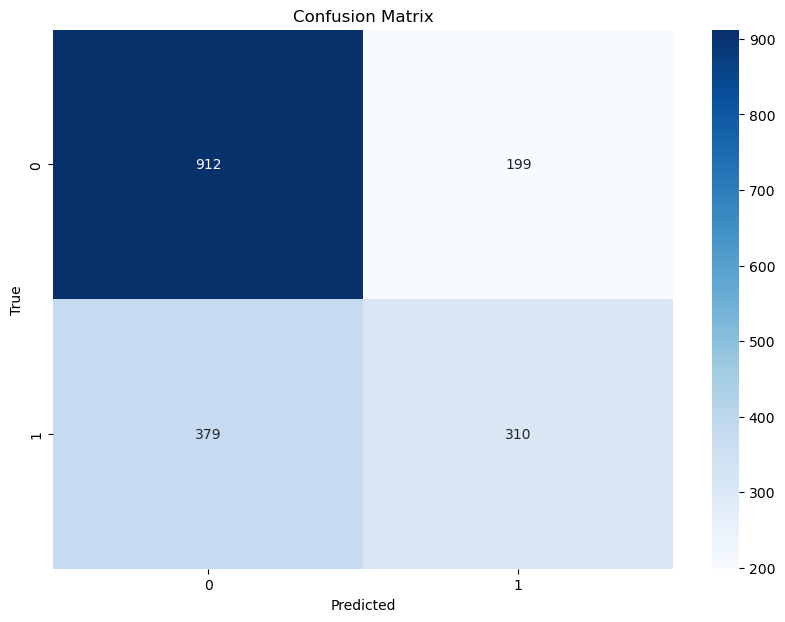

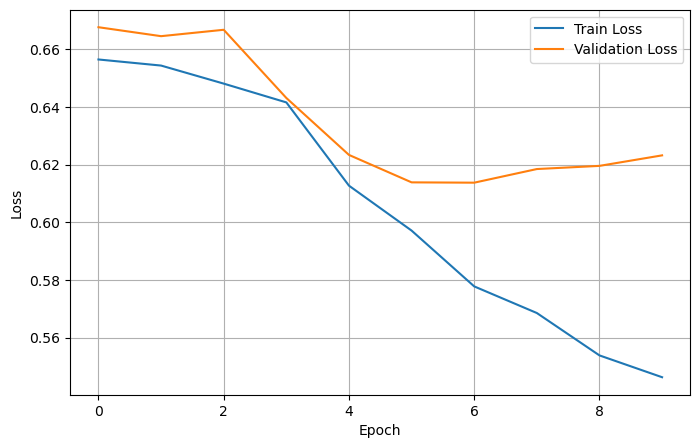

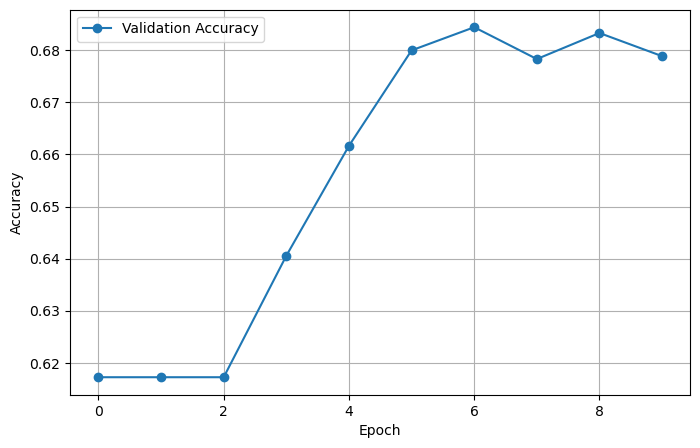

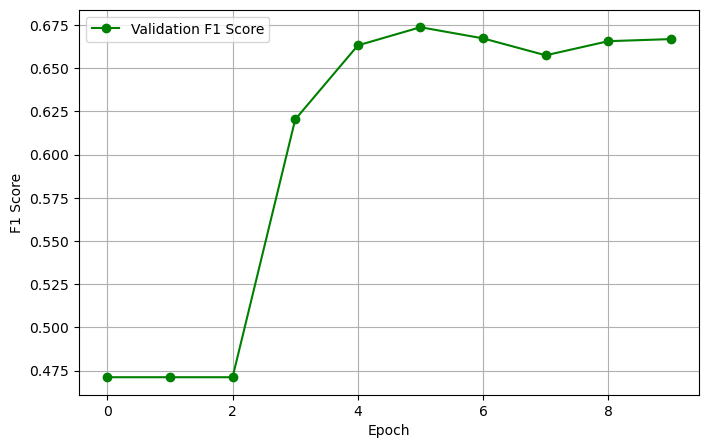

In [8]:
# ====================== Imports ======================
import os
import json
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipModel
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ====================== CONFIG ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_DIR = "data/img"
JSONL_PATH = "data/dataset.jsonl"
NUM_LABELS = 2
LABEL_MAP = {0: 'non-hateful', 1: 'hateful'}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
BATCH_SIZE = 8
EPOCHS = 10

# ====================== Load JSONL with validation ======================
records = []
with open(JSONL_PATH, "r", encoding="utf-8") as f:
    for line in f:
        try:
            data = json.loads(line.strip())
            if all(k in data for k in ['label', 'text', 'img']):
                records.append(data)
            else:
                print(f"Skipping incomplete record: {data}")
        except json.JSONDecodeError:
            print(f"Skipping bad JSON: {line.strip()}")

# ====================== Dataset ======================
class MemeDataset(Dataset):
    def __init__(self, records, processor, img_dir):
        self.data = records
        self.processor = processor
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        image_path = os.path.join(self.img_dir, os.path.basename(row['img']))

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")

        image = Image.open(image_path).convert("RGB")
        text = str(row['text'])
        label = row['label']

        inputs = self.processor(images=image, text=text, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = torch.tensor(label)

        return inputs

# ====================== Model ======================
class BLIPClassificationHead(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.blip = BlipModel.from_pretrained("Salesforce/blip-itm-base-coco")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(512, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        outputs = self.blip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )
        pooled_output = self.dropout(outputs.image_embeds)
        logits = self.classifier(pooled_output)

        loss = self.loss_fn(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}

# ====================== Train & Eval ======================
def train(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs, labels=labels)

        loss = outputs["loss"]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            logits = outputs["logits"]
            loss = outputs["loss"]
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return acc, avg_loss, all_preds, all_labels

def custom_collate(batch):
    keys = batch[0].keys()
    collated = {}
    for key in keys:
        if key == "labels":
            collated[key] = torch.tensor([item[key] for item in batch])
        else:
            collated[key] = torch.nn.utils.rnn.pad_sequence(
                [item[key] for item in batch],
                batch_first=True,
                padding_value=0
            )
    return collated

# ====================== Run ======================
processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
dataset = MemeDataset(records, processor, IMG_DIR)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)

model = BLIPClassificationHead(num_labels=NUM_LABELS).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ====================== Training Loop ======================
train_losses, val_losses = [], []
val_accuracies, val_f1s = [], []
final_preds, final_labels = [], []
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train(model, train_loader, optimizer)
    train_losses.append(train_loss)

    val_acc, val_loss, preds, labels = evaluate(model, val_loader)
    val_losses.append(val_loss)

    f1 = f1_score(labels, preds, average='weighted')
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

    val_accuracies.append(val_acc)
    val_f1s.append(f1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")

    scheduler.step()
    final_preds = preds
    final_labels = labels

# ====================== Final Eval & Plots ======================
print("\nClassification Report:")
print(classification_report(final_labels, final_preds, target_names=[str(k) for k in LABEL_MAP.keys()]))

os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(final_labels, final_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("plots/loss_plot.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("plots/accuracy_plot.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_f1s, label="Validation F1 Score", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.savefig("plots/f1_score_plot.png")
plt.show()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Skipping incomplete record: {'id': 16395, 'img': 'img/16395.png', 'text': 'handjobs sold seperately'}
Skipping incomplete record: {'id': 37405, 'img': 'img/37405.png', 'text': 'introducing fidget spinner for women'}
Skipping incomplete record: {'id': 94180, 'img': 'img/94180.png', 'text': "happy pride month let's go beat up lesbians"}
Skipping incomplete record: {'id': 54321, 'img': 'img/54321.png', 'text': 'laughs in [majority of u.s crime rate]'}
Skipping incomplete record: {'id': 97015, 'img': 'img/97015.png', 'text': 'finds out those 72 virgins.. are goats'}
Skipping incomplete record: {'id': 73506, 'img': 'img/73506.png', 'text': 'look your dad fucked goats.. i capped him...sorry..'}
Skipping incomplete record: {'id': 5429, 'img': 'img/05429.png', 'text': 'claims that her ancestors created a safe space for jews these are her ancestors'}
Skipping incomplete record: {'id': 70691, 'img': 'img/70691.png', 'text': 'overdose'}
Skipping incomplete record: {'id': 69421, 'img': 'img/69421.

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.enco


Epoch 1/15


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.84it/s]


Train Loss: 0.6589 | Val Loss: 0.6559 | Val Acc: 0.6350 | Val F1: 0.4932

Epoch 2/15


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.84it/s]


Train Loss: 0.6570 | Val Loss: 0.6564 | Val Acc: 0.6350 | Val F1: 0.4932

Epoch 3/15


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.81it/s]


Train Loss: 0.6577 | Val Loss: 0.6558 | Val Acc: 0.6350 | Val F1: 0.4932

Epoch 4/15


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.81it/s]


Train Loss: 0.6567 | Val Loss: 0.6552 | Val Acc: 0.6350 | Val F1: 0.4932

Epoch 5/15


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.79it/s]


Train Loss: 0.6519 | Val Loss: 0.6453 | Val Acc: 0.6350 | Val F1: 0.4932

Epoch 6/15


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.79it/s]


Train Loss: 0.6349 | Val Loss: 0.6265 | Val Acc: 0.6678 | Val F1: 0.6426

Epoch 7/15


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.78it/s]


Train Loss: 0.6104 | Val Loss: 0.6195 | Val Acc: 0.6739 | Val F1: 0.6480

Epoch 8/15


Evaluating: 100%|██████████| 225/225 [00:39<00:00,  5.76it/s]


Train Loss: 0.6008 | Val Loss: 0.6137 | Val Acc: 0.6894 | Val F1: 0.6699

Epoch 9/15


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.77it/s]


Train Loss: 0.5878 | Val Loss: 0.6099 | Val Acc: 0.6900 | Val F1: 0.6676

Epoch 10/15


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.78it/s]


Train Loss: 0.5809 | Val Loss: 0.6094 | Val Acc: 0.6906 | Val F1: 0.6602

Epoch 11/15


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.78it/s]


Train Loss: 0.5726 | Val Loss: 0.6083 | Val Acc: 0.6900 | Val F1: 0.6686

Epoch 12/15


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.77it/s]


Train Loss: 0.5669 | Val Loss: 0.6107 | Val Acc: 0.6861 | Val F1: 0.6684

Epoch 13/15


Evaluating: 100%|██████████| 225/225 [00:38<00:00,  5.77it/s]


Train Loss: 0.5626 | Val Loss: 0.6107 | Val Acc: 0.6856 | Val F1: 0.6646

Epoch 14/15


Evaluating: 100%|██████████| 225/225 [00:39<00:00,  5.76it/s]


Train Loss: 0.5592 | Val Loss: 0.6119 | Val Acc: 0.6850 | Val F1: 0.6636

Epoch 15/15


Evaluating: 100%|██████████| 225/225 [00:39<00:00,  5.74it/s]

Train Loss: 0.5556 | Val Loss: 0.6109 | Val Acc: 0.6856 | Val F1: 0.6644

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.86      0.78      1143
           1       0.61      0.38      0.47       657

    accuracy                           0.69      1800
   macro avg       0.66      0.62      0.62      1800
weighted avg       0.67      0.69      0.66      1800



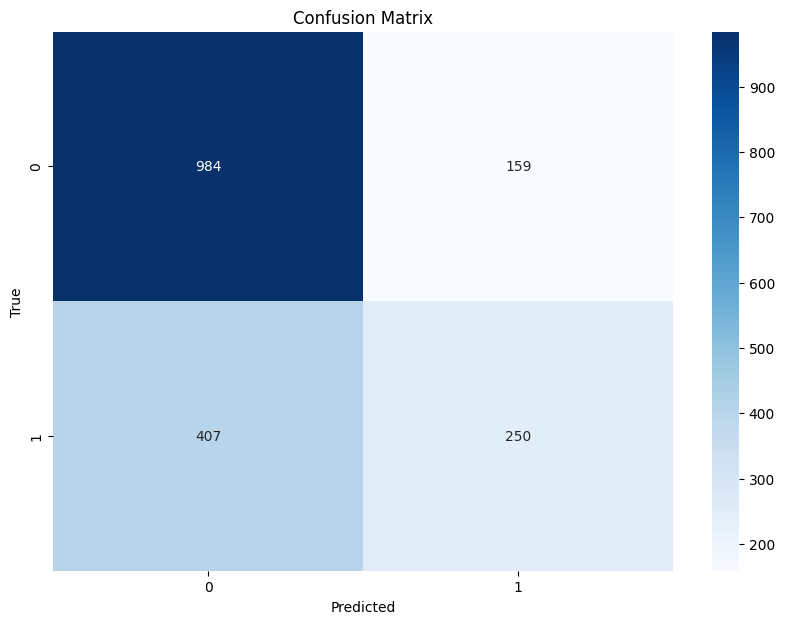

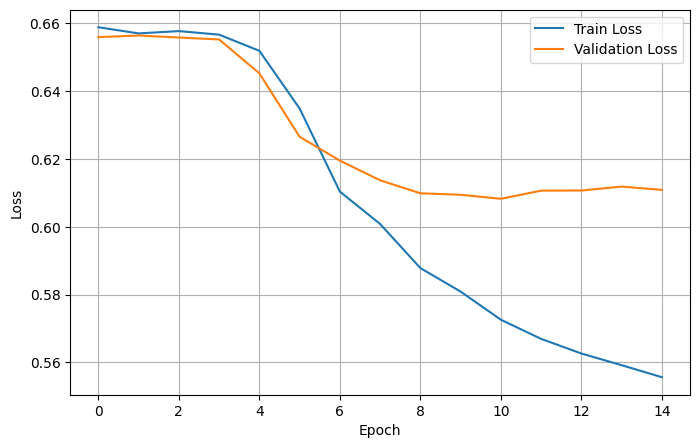

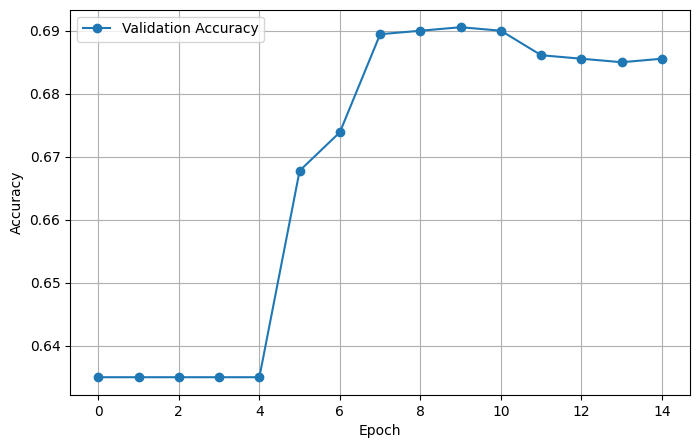

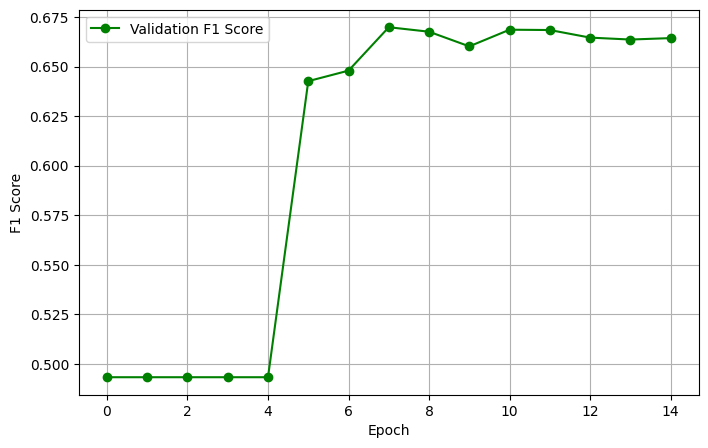

In [1]:
# ====================== Imports ======================
import os
import json
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipModel
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ====================== CONFIG ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_DIR = "data/img"
JSONL_PATH = "data/dataset.jsonl"
NUM_LABELS = 2
LABEL_MAP = {0: 'non-hateful', 1: 'hateful'}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
BATCH_SIZE = 8
EPOCHS = 15

# ====================== Load JSONL with validation ======================
records = []
with open(JSONL_PATH, "r", encoding="utf-8") as f:
    for line in f:
        try:
            data = json.loads(line.strip())
            if all(k in data for k in ['label', 'text', 'img']):
                records.append(data)
            else:
                print(f"Skipping incomplete record: {data}")
        except json.JSONDecodeError:
            print(f"Skipping bad JSON: {line.strip()}")

# ====================== Dataset ======================
class MemeDataset(Dataset):
    def __init__(self, records, processor, img_dir):
        self.data = records
        self.processor = processor
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        image_path = os.path.join(self.img_dir, os.path.basename(row['img']))

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")

        image = Image.open(image_path).convert("RGB")
        text = str(row['text'])
        label = row['label']

        inputs = self.processor(images=image, text=text, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = torch.tensor(label)

        return inputs

# ====================== Model ======================
class BLIPClassificationHead(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.blip = BlipModel.from_pretrained("Salesforce/blip-itm-base-coco")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(512, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        outputs = self.blip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )
        pooled_output = self.dropout(outputs.image_embeds)
        logits = self.classifier(pooled_output)

        loss = self.loss_fn(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}

# ====================== Train & Eval ======================
def train(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs, labels=labels)

        loss = outputs["loss"]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            logits = outputs["logits"]
            loss = outputs["loss"]
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return acc, avg_loss, all_preds, all_labels

def custom_collate(batch):
    keys = batch[0].keys()
    collated = {}
    for key in keys:
        if key == "labels":
            collated[key] = torch.tensor([item[key] for item in batch])
        else:
            collated[key] = torch.nn.utils.rnn.pad_sequence(
                [item[key] for item in batch],
                batch_first=True,
                padding_value=0
            )
    return collated

# ====================== Run ======================
processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
dataset = MemeDataset(records, processor, IMG_DIR)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)

model = BLIPClassificationHead(num_labels=NUM_LABELS).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ====================== Training Loop ======================
train_losses, val_losses = [], []
val_accuracies, val_f1s = [], []
final_preds, final_labels = [], []
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train(model, train_loader, optimizer)
    train_losses.append(train_loss)

    val_acc, val_loss, preds, labels = evaluate(model, val_loader)
    val_losses.append(val_loss)

    f1 = f1_score(labels, preds, average='weighted')
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

    val_accuracies.append(val_acc)
    val_f1s.append(f1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")

    scheduler.step()
    final_preds = preds
    final_labels = labels

# ====================== Final Eval & Plots ======================
print("\nClassification Report:")
print(classification_report(final_labels, final_preds, target_names=[str(k) for k in LABEL_MAP.keys()]))

os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(final_labels, final_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("plots/loss_plot.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("plots/accuracy_plot.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_f1s, label="Validation F1 Score", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.savefig("plots/f1_score_plot.png")
plt.show()
